
# Phase C – Broker Bleed-out Demo

This notebook shows **implicit divorce**:
a lower-level Broker loses relevance when a Stack
enters a higher capital market.

There is **no explicit detach logic**.
The lower broker simply *bleeds out*.


In [3]:

# Imports
import numpy as np
import matplotlib.pyplot as plt

from capitalmarket.capitalselector.broker import Broker, BrokerConfig
from capitalmarket.capitalselector.channels import GaussianExplorer
from capitalmarket.capitalselector.stack import StackChannel
from capitalmarket.capitalselector.builder import CapitalSelectorBuilder



## Setup: Two Markets


In [4]:

# Lower market (L0)
explorers_L0 = {
    "A": GaussianExplorer(mu=1.0, sigma=0.2, seed=1),
    "B": GaussianExplorer(mu=1.0, sigma=0.2, seed=2),
    "C": GaussianExplorer(mu=0.0, sigma=1.5, seed=3),
}

broker_L0 = Broker(BrokerConfig())
# Selector dimension equals number of current explorers (will resync in loop)
selector_L0 = (
    CapitalSelectorBuilder()
    .with_K(len(explorers_L0))
    .with_initial_wealth(1.0)
    .with_rebirth_threshold(-1e9)
    .build()
)

# Upper market (L1)
broker_L1 = Broker(BrokerConfig())
selector_L1 = (
    CapitalSelectorBuilder()
    .with_K(1)  # single channel "S" representing the stack
    .with_initial_wealth(1.0)
    .with_rebirth_threshold(-1e9)
    .build()
)

stack = None
T = 500

vol_L0, vol_L1 = [], []



## Event Loop


In [5]:

for t in range(T):
    # ---- L0 ----
    ids_L0 = list(explorers_L0.keys())

    # Sync selector dimension to current number of explorers
    selector_L0.K = len(ids_L0)
    if selector_L0.w is None or len(selector_L0.w) != len(ids_L0):
        selector_L0.w = np.ones(len(ids_L0)) / max(1, len(ids_L0))

    w0_raw = selector_L0.allocate()
    raw0 = {eid: float(w0_raw[i]) for i, eid in enumerate(ids_L0)}

    broker_L0.decide_limits()
    w0 = broker_L0.apply_policies(raw0)

    r_vec0 = np.zeros(len(ids_L0), dtype=float)
    c_total0 = 0.0
    for i, eid in enumerate(ids_L0):
        wi = w0.get(eid, 0.0)
        if wi <= 0.0:
            continue
        r, c, alive, dt = explorers_L0[eid].step(wi)
        broker_L0.observe(eid, r, c, alive, dt)
        r_vec0[i] = float(r)
        c_total0 += float(c)

    selector_L0.feedback_vector(r_vec0, c_total0)

    # form stack once A and B are present (simple trigger for demo)
    if stack is None and "A" in explorers_L0 and "B" in explorers_L0:
        members = {"A": explorers_L0["A"], "B": explorers_L0["B"]}
        stack = StackChannel(members)
        del explorers_L0["A"]
        del explorers_L0["B"]

    # ---- L1 ----
    if stack is not None:
        # Single channel "S" in upper market
        if selector_L1.w is None or len(selector_L1.w) != 1:
            selector_L1.w = np.ones(1) / 1.0
        w1_raw = selector_L1.allocate()
        raw1 = {"S": float(w1_raw[0])}

        broker_L1.decide_limits()
        w1 = broker_L1.apply_policies(raw1)

        r, c, alive, dt = stack.step(w1.get("S", 0.0))
        broker_L1.observe("S", r, c, alive, dt)
        selector_L1.feedback_vector(np.array([float(r)], dtype=float), float(c))
    else:
        w1 = {"S": 0.0}

    vol_L0.append(sum(w0.values()))
    vol_L1.append(sum(w1.values()))



## Plot – Broker Bleed-out


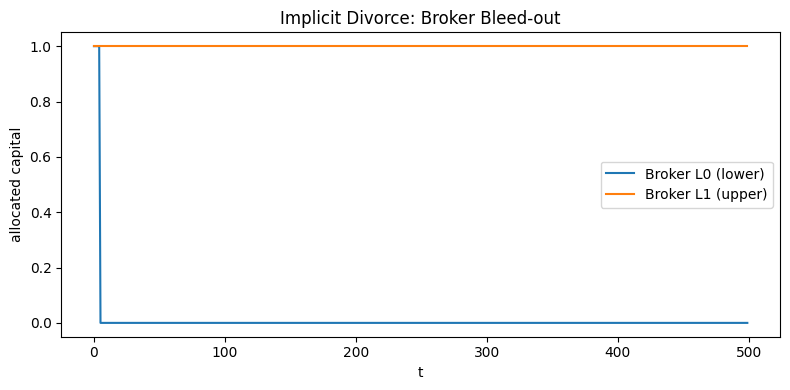

In [6]:

plt.figure(figsize=(8,4))
plt.plot(vol_L0, label="Broker L0 (lower)")
plt.plot(vol_L1, label="Broker L1 (upper)")
plt.title("Implicit Divorce: Broker Bleed-out")
plt.xlabel("t")
plt.ylabel("allocated capital")
plt.legend()
plt.tight_layout()
plt.show()
